In [171]:
import pandas as pd # Обновить pandas до последней версии
import numpy as np
import math
import os
import glob
import mysql.connector
import datetime
from mysql.connector import errorcode
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string


import warnings
warnings.filterwarnings("ignore")

In [172]:
user = 'root'
password = ''

## Добавляем в БД таблицу платежей по контрактам

In [173]:
payments_table = pd.read_excel('payments.xls')

In [174]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

cursor.execute("""CREATE TABLE IF NOT EXISTS payments 
(id INT NOT NULL UNIQUE,
contract_number INT, 
date DATE, 
amount_due INT,
amount_paid INT, 
PRIMARY KEY (id))""")

cnx.commit()

In [175]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

for i in range(0, payments_table.shape[0]):
    cursor.execute(""" INSERT INTO payments 
    VALUES 
    (%s, %s, '%s', %s, %s)""" % (
        i,
        payments_table['Contract Number'][i],
        payments_table['Date'][i],
        payments_table['Amount Due'][i], 
        payments_table['Amount Paid'][i] 
        ))

cnx.commit()

## (а) Моменты просрочки 90+ для каждого контракта

##### Выгружаем из БД таблицу по платежам

In [176]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

payments_table = pd.read_sql_query("SELECT * FROM payments", cnx)
payments_table.keys()

Index(['id', 'contract_number', 'date', 'amount_due', 'amount_paid'], dtype='object')

##### Получаем список дефолтов по контрактам

In [177]:
contract_number = list(payments_table['contract_number'])
contract_number_unique = list(set(contract_number)) #получаем список номеров контрактов
print (contract_number_unique)

[100737, 100610, 100869, 100614, 100997, 100743, 100872, 100875, 100620, 100493, 100368, 100113, 100375, 100122, 100506, 100380, 100765, 100127, 100516, 100901, 100518, 101028, 100520, 100648, 100856, 100524, 100022, 100668, 100797, 100414, 100540, 100929, 100932, 100933, 100552, 100297, 100684, 100431, 100176, 100303, 100689, 100052, 100441, 100190, 100703, 100320, 100321, 100958, 100323, 100068, 100582, 100455, 100585, 100206, 100847, 100851, 100211, 100468, 100600, 100476, 100990]


In [178]:
default_info = [] #лист дефолтов - переменная, куда будет добавляться информация типа (номер конракта, дата просрочки)

In [179]:
for i in contract_number_unique:
    table = payments_table[payments_table['contract_number'] == i]
    table = table.reset_index()
    for j in range(0, table.shape[0]-3):
        if (table['amount_paid'][j] < table['amount_due'][j] and table['amount_paid'][j+1] < table['amount_due'][j+1] and
                table['amount_paid'][j+2] < table['amount_due'][j+2] and table['amount_paid'][j+3] < table['amount_due'][j+3]):
                #проверяем, что заемщик не платит 4 даты подряд
                default_date = table['date'][j+3] #фиксируем дату просрочки
                default_date = (str(pd.to_datetime(default_date).year) + '-' + str(pd.to_datetime(default_date).month) + 
                           '-' + str(pd.to_datetime(default_date).day)) #корректируем формат даты просрочки
                default_info.append ((i, default_date)) #добавляем дату просрочки всместе с номером контракта в лист дефолтов
                break

default_info   

[(100875, '2017-3-5'),
 (100375, '2017-1-2'),
 (100901, '2016-11-3'),
 (100668, '2018-6-29'),
 (100684, '2017-12-14'),
 (100052, '2017-12-30')]

##### Добавляем в таблицу контрактов данные о дефолтах

In [180]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

cursor.execute("""ALTER TABLE contracts ADD date_of_90_day_default DATE""")

for i in default_info:
    cursor.execute("""UPDATE contracts SET date_of_90_day_default = '%s' WHERE contract_number = %s """ %(i[1], i[0]))

cnx.commit()
cnx.close()

## (b, c)  Задание горизонта риска + таблица заемщиков на заданном горизонте с флагом дефолт/недефолт

##### Предлагаем пользователю задать горизонт риска

In [181]:
print ('Задайте горизонт риска (в месяцах с начала заключения контракта)')
ask_risk_horizon = input()

Задайте горизонт риска (в месяцах с начала заключения контракта)
19


In [182]:
risk_horizon = int(ask_risk_horizon) #меняем формат введенной переменной на числовой
risk_horizon

19

##### Создаем лист дефолтов на горизонте риска с флагом дефолт/недефолт

In [183]:
default_info_with_risk_horizon = [] #лист дефолтов на горизонте риска - переменная, куда буду добавляться данные типа
                                    #(номер контракта, дата дефолта, флаг дефолт/недефолт)

In [209]:
for i in contract_number_unique:
    table = payments_table[payments_table['contract_number'] == i]
    if table.shape[0] >= risk_horizon:
        table = table[:risk_horizon]
        table = table.reset_index()
        for j in range(0, table.shape[0]-3):
            if (table['amount_paid'][j] < table['amount_due'][j] and table['amount_paid'][j+1] < table['amount_due'][j+1] and
                table['amount_paid'][j+2] < table['amount_due'][j+2] and table['amount_paid'][j+3] < table['amount_due'][j+3]):
                #проверяем, что заемщик не платит 4 даты подряд
                default_date = table['date'][j + 3] #фиксируем дату просрочки
                default_date = (str(pd.to_datetime(default_date).year) + '-' + str(pd.to_datetime(default_date).month) + 
                                '-' + str(pd.to_datetime(default_date).day)) #корректируем формат даты просрочки
                while (i, '0000-00-00', 0) in default_info_with_risk_horizon:
                                default_info_with_risk_horizon.remove ((i, '0000-00-00', 0)) 
                        #исключаем из нашего листа дефолтов нулевые даты для дефолтеров
                default_info_with_risk_horizon.append((i, default_date, 1)) 
                break 
            else: default_info_with_risk_horizon.append((i, '0000-00-00', 0))
    
default_info_with_risk_horizon[:5]

[(100441, '0000-00-00', 0),
 (100190, '0000-00-00', 0),
 (100958, '0000-00-00', 0),
 (100847, '0000-00-00', 0),
 (100869, '0000-00-00', 0)]

In [185]:
default_info_with_risk_horizon = list(set(default_info_with_risk_horizon))
print (len(default_info_with_risk_horizon))
default_info_with_risk_horizon

43


[(100441, '0000-00-00', 0),
 (100190, '0000-00-00', 0),
 (100958, '0000-00-00', 0),
 (100847, '0000-00-00', 0),
 (100869, '0000-00-00', 0),
 (100997, '0000-00-00', 0),
 (100176, '0000-00-00', 0),
 (100743, '0000-00-00', 0),
 (100068, '0000-00-00', 0),
 (100765, '0000-00-00', 0),
 (100668, '2018-6-29', 1),
 (100127, '0000-00-00', 0),
 (100476, '0000-00-00', 0),
 (100518, '0000-00-00', 0),
 (100689, '0000-00-00', 0),
 (100431, '0000-00-00', 0),
 (100524, '0000-00-00', 0),
 (100303, '0000-00-00', 0),
 (100585, '0000-00-00', 0),
 (100455, '0000-00-00', 0),
 (100552, '0000-00-00', 0),
 (100737, '0000-00-00', 0),
 (100206, '0000-00-00', 0),
 (100320, '0000-00-00', 0),
 (100856, '0000-00-00', 0),
 (100600, '0000-00-00', 0),
 (100933, '0000-00-00', 0),
 (100368, '0000-00-00', 0),
 (100297, '0000-00-00', 0),
 (100022, '0000-00-00', 0),
 (101028, '0000-00-00', 0),
 (100684, '2017-12-14', 1),
 (100520, '0000-00-00', 0),
 (100703, '0000-00-00', 0),
 (100540, '0000-00-00', 0),
 (100323, '0000-00-00

##### Строим в БД таблицу заемщиков с кредитами сроком не меньше горизонта риска с флагом {дефолт/недефолт} на выбранном горизонте

In [186]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

cursor.execute("""CREATE TABLE IF NOT EXISTS contracts_risk_horizon_{0}_months 
(contract_number INT, 
bankruptcy BOOLEAN, 
date_of_default DATE)""".format(risk_horizon))

cnx.commit()
cnx.close()

In [187]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

for i in default_info_with_risk_horizon:
    cursor.execute("""INSERT INTO contracts_risk_horizon_{0}_months 
    VALUES
    (%d, %d, '%s')""".format(risk_horizon) % (
    i[0],
    i[2],
    i[1]))
    
cnx.commit()
cnx.close()

## (f)* Отправляем в БД информацию о моментах дефолтов обратно в виде отдельной таблицы "id - флаг дефолт/недефолт"

In [188]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

cursor.execute("""CREATE TABLE borrowers_default_with_risk_horizon_{0} AS (select A.id, bankruptcy from
(select bankruptcy, id
from contracts
inner join contracts_risk_horizon_19_months on
contracts.contract_number = contracts_risk_horizon_19_months.contract_number) as A
inner join applications on
applications.id = A.id)""".format(risk_horizon))

cnx.commit()
cnx.close()

## (d, e) WOE, IV

##### Выбираем категориальные переменные с учетом дефолта

In [189]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

applications_df = pd.read_sql_query("SELECT * FROM applications", cnx)
applications_df.keys()

Index(['id', 'income', 'age_of_car', 'issue_date', 'children', 'family',
       'gender', 'application_date', 'age', 'income_type_enc', 'housing_enc',
       'marital_status_enc', 'employed_by_enc', 'position_enc',
       'house_ownership_enc', 'education_enc'],
      dtype='object')

In [190]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

applications_with_risk_horizon = pd.read_sql_query("""select bankruptcy, children, family, gender, marital_status_enc,
employed_by_enc, education_enc, position_enc, income_type_enc, housing_enc, house_ownership_enc from
(select bankruptcy, id
from contracts
inner join contracts_risk_horizon_{0}_months on
contracts.contract_number = contracts_risk_horizon_{1}_months.contract_number) as A
inner join applications on
applications.id = A.id""".format(risk_horizon, risk_horizon), cnx)

In [191]:
applications_with_risk_horizon.head(5)

,bankruptcy,children,family,gender,marital_status_enc,employed_by_enc,education_enc,position_enc,income_type_enc,housing_enc,house_ownership_enc
0,0,0,2,0,1,14,0,4,3,0,0
1,0,0,1,1,4,5,3,6,4,0,2
2,0,0,1,1,4,13,3,4,4,0,2
3,0,0,2,1,1,12,3,6,3,0,2
4,0,1,3,0,1,1,0,1,0,0,2


##### Строим таблицу для показателей WOE и IV для категориальных переменных (ссылка на github, откуда была взята следующая функция: https://github.com/Sundar0989/WOE-and-IV )

In [192]:
max_bin = 20
force_bin = 4

# define a binning function
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def woe_iv_categorical(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            conv = char_bin(target, df1[i])
            conv["VAR_NAME"] = i
            count = count + 1
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [193]:
woe_and_iv_categorical = woe_iv_categorical(applications_with_risk_horizon, applications_with_risk_horizon.bankruptcy)[0]
woe_and_iv_categorical

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,children,0,0,32,2,0.062500,30,0.937500,1.0,0.731707,0.312375,0.083808
1,children,1,1,10,0,0.000000,10,1.000000,0.0,0.243902,0.000000,0.083808
2,children,2,2,1,0,0.000000,1,1.000000,0.0,0.024390,0.000000,0.083808
3,family,1,1,10,1,0.100000,9,0.900000,0.5,0.219512,0.823200,0.237914
4,family,2,2,24,1,0.041667,23,0.958333,0.5,0.560976,-0.115069,0.237914
5,family,3,3,8,0,0.000000,8,1.000000,0.0,0.195122,0.000000,0.237914
6,family,4,4,1,0,0.000000,1,1.000000,0.0,0.024390,0.000000,0.237914
7,gender,0,0,23,1,0.043478,22,0.956522,0.5,0.536585,-0.070618,0.005364
8,gender,1,1,20,1,0.050000,19,0.950000,0.5,0.463415,0.075986,0.005364
9,marital_status_enc,0,0,4,0,0.000000,4,1.000000,0.0,0.097561,0.000000,1.081996


##### Предлагаем пользователю задать категориальныую переменную для построения графика WOE

In [194]:
print('Задайте категориальную переменную для построения графика:')
cat_var = input()

Задайте категориальную переменную для построения графика:
income_type_enc


In [195]:
cat_var

'income_type_enc'

In [196]:
df_cat_var = woe_and_iv_categorical[woe_and_iv_categorical['VAR_NAME'] == cat_var]
df_cat_var

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
50,income_type_enc,0,0,7,0,0.000000,7,1.000000,0.0,0.170732,0.00000,0.288489
51,income_type_enc,2,2,5,0,0.000000,5,1.000000,0.0,0.121951,0.00000,0.288489
52,income_type_enc,3,3,7,0,0.000000,7,1.000000,0.0,0.170732,0.00000,0.288489
53,income_type_enc,4,4,24,2,0.083333,22,0.916667,1.0,0.536585,0.62253,0.288489


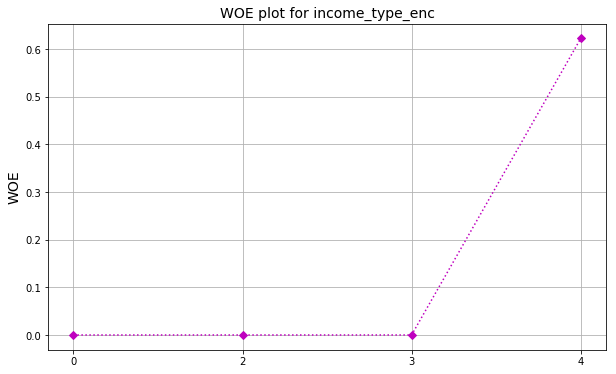

In [197]:
%matplotlib inline 

plt.figure(figsize=(10, 6));
plt.plot(list(range(df_cat_var.shape[0])), df_cat_var.WOE, 'mD:')
plt.grid()
plt.xticks(list(range(df_cat_var.shape[0])), df_cat_var.MIN_VALUE)
plt.ylabel("WOE", fontsize=14)

plt.title("WOE plot for {0}".format(cat_var), fontsize=14)
plt.show()

In [198]:
cat_var1 = cat_var[:-4] #ключи в словарях оканчиваются на _enc, нужно отбросить последние 4 знака

In [199]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

keys = pd.read_sql_query("""SELECT * FROM keys_applications WHERE feature = '{0}' """.format(cat_var1), cnx)
keys #выведем ключи, чтобы поянить график

,feature,keys_f,values_f
0,income_type,State servant,3
1,income_type,Working,4
2,income_type,Commercial associate,0
3,income_type,Pensioner,2
4,income_type,NULL,1


##### Строим IV (+2 графика)

In [200]:
iv_categorical = woe_and_iv_categorical[['VAR_NAME', 'IV']].drop_duplicates().copy()
iv_categorical = iv_categorical.reset_index()
iv_categorical = iv_categorical.drop(['index'], axis = 1)
iv_categorical

,VAR_NAME,IV
0,children,0.083808
1,family,0.237914
2,gender,0.005364
3,marital_status_enc,1.081996
4,employed_by_enc,1.871072
5,education_enc,0.166637
6,position_enc,0.230898
7,income_type_enc,0.288489
8,housing_enc,0.005560
9,house_ownership_enc,0.054403


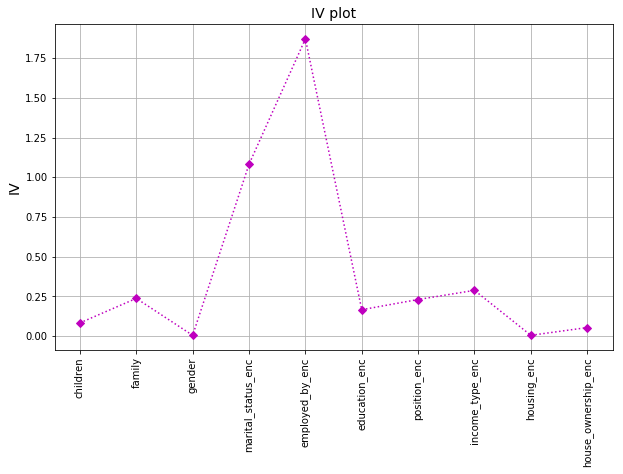

In [201]:
plt.figure(figsize=(10, 6));
plt.plot(list(range(iv_categorical.shape[0])), iv_categorical.IV, 'mD:')
plt.grid()
plt.xticks(list(range(iv_categorical.shape[0])), iv_categorical.VAR_NAME, rotation='vertical')
plt.ylabel("IV", fontsize=14)

plt.title("IV plot", fontsize=14)
plt.show()

##### Квантилизируем непрерывные переменные

In [202]:
applications_df.keys()

Index(['id', 'income', 'age_of_car', 'issue_date', 'children', 'family',
       'gender', 'application_date', 'age', 'income_type_enc', 'housing_enc',
       'marital_status_enc', 'employed_by_enc', 'position_enc',
       'house_ownership_enc', 'education_enc'],
      dtype='object')

In [203]:
cnx = mysql.connector.connect(host = 'localhost', database = 'hw_db', user = user, password = password)
cursor = cnx.cursor()

applications_with_risk_horizon = pd.read_sql_query("""SELECT bankruptcy, age, income, age_of_car FROM
(SELECT bankruptcy, id
FROM contracts
INNER JOIN contracts_risk_horizon_{0}_months on
contracts.contract_number = contracts_risk_horizon_{1}_months.contract_number) AS A
INNER JOIN applications ON
applications.id = A.id""".format(risk_horizon, risk_horizon), cnx)

cnx.close()
applications_with_risk_horizon.head(5)

,bankruptcy,age,income,age_of_car
0,0,50,270000.0,NaN
1,0,54,67500.0,26.0
2,0,55,121500.0,NaN
3,0,50,99000.0,NaN
4,0,40,171000.0,17.0


In [204]:
max_bin = 20 #по желанию устанавливаем максимальное число разбиений
force_bin = 3 #минимальное число разбиений

In [205]:
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)


def woe_iv_cont(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [206]:
woe_and_iv_cont = woe_iv_cont(applications_with_risk_horizon, applications_with_risk_horizon.bankruptcy)[0]
woe_and_iv_cont = woe_and_iv_cont.dropna()
woe_and_iv_cont

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,age,21.0,27.0,3,0.0,0.000000,3.0,1.000000,0.0,0.073171,0.000000,2.486657
1,age,29.0,31.0,2,0.0,0.000000,2.0,1.000000,0.0,0.048780,0.000000,2.486657
2,age,32.0,33.0,2,0.0,0.000000,2.0,1.000000,0.0,0.048780,0.000000,2.486657
3,age,34.0,34.0,2,0.0,0.000000,2.0,1.000000,0.0,0.048780,0.000000,2.486657
4,age,35.0,36.0,2,0.0,0.000000,2.0,1.000000,0.0,0.048780,0.000000,2.486657
5,age,37.0,39.0,2,0.0,0.000000,2.0,1.000000,0.0,0.048780,0.000000,2.486657
6,age,40.0,40.0,4,0.0,0.000000,4.0,1.000000,0.0,0.097561,0.000000,2.486657
8,age,41.0,43.0,2,0.0,0.000000,2.0,1.000000,0.0,0.048780,0.000000,2.486657
9,age,46.0,47.0,3,0.0,0.000000,3.0,1.000000,0.0,0.073171,0.000000,2.486657
10,age,50.0,50.0,4,0.0,0.000000,4.0,1.000000,0.0,0.097561,0.000000,2.486657


In [207]:
iv_cont = woe_and_iv_cont[['VAR_NAME', 'IV']].drop_duplicates().copy()
iv_cont = iv_cont.reset_index()
iv_cont = iv_cont.drop(['index'], axis = 1)
iv_cont

,VAR_NAME,IV
0,age,2.486657
1,income,1.092166
2,age_of_car,0.877319


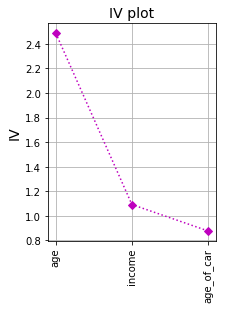

In [208]:
plt.figure(figsize=(3, 4));
plt.plot(list(range(iv_cont.shape[0])), iv_cont.IV, 'mD:')
plt.grid()
plt.xticks(list(range(iv_cont.shape[0])), iv_cont.VAR_NAME, rotation='vertical')
plt.ylabel("IV", fontsize=14)

plt.title("IV plot", fontsize=14)
plt.show()